<a href="https://colab.research.google.com/github/rkique/hardlyimagined/blob/master/256GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Loading in images...
[[ 0.02170294  0.47832518  0.92705796 ... -0.02380616  0.753482
  -0.27793565]
 [-0.94804411  0.25685576 -0.82267442 ... -0.10041461 -0.70375658
  -0.76226503]]
there were 0 missing files


Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model Build Successful!
Model 9999 loaded successfully!
Training Round 25000:


Dis_Loss_Real: 0.26804    Dis_Loss_Fake: 0.1783509     Generator_Loss: 3.0814195
Step duration: 31.988160610198975
Training Round 25001:
Dis_Loss_Real: 0.16759449    Dis_Loss_Fake: 0.19616072     Generator_Loss: 3.3032522


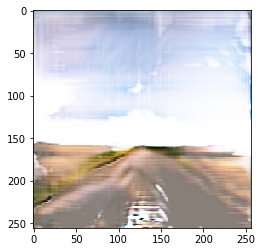

Step duration: 40.08134865760803
Training Round 25002:


In [0]:
# -*- coding: utf-8 -*-
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from math import floor
import time
import glob, os
#noise amounts increased from 0.01 variation to 0.1
def zero():
    return np.random.uniform(0.0, 0.10, size = [1])

def one():
    return np.random.uniform(0.90, 1.0, size = [1])

def noise(n):
    return np.random.uniform(-1.0, 1.0, size = [n, 4096])

print("Loading in images...")
print(noise(2))
Images = []
i = 0;

os.chdir("/content/drive/My Drive/Colab Notebooks/Sprites")
for file in glob.glob("*.png"):
    try:
      temp1 = Image.open(file)
      temp = np.array(temp1.convert('RGB'), dtype='float32')
      Images.append(temp / 255)
      #adds extra data through lr flipping
      Images.append(np.flip(Images[-1], 1))
    except:
    #troubleshooting
      i = i+1;  
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dense, AveragePooling2D
from keras.layers import Reshape, UpSampling2D, Activation, Dropout, Flatten, Conv2DTranspose
from keras.models import model_from_json, Sequential
from keras.optimizers import Adam
    
class GAN(object):
    #high, horizontally oriented kernels make sense for landscapes
    k_size = [9,5]
    def __init__(self):
        
        #init model variables
        self.D = None
        self.G = None
        
        self.OD = None
        
        self.DM = None
        self.AM = None
        
        #Config
        self.LR = 0.0001
        self.steps = 1

    def StdConv2D(this,filters, kernel_size):
        this.add(Conv2D(filters = filters, kernel_size = kernel_size, padding = 'same'))
        this.add(BatchNormalization(momentum = 0.7))
        this.add(Activation('relu'))
        this.add(UpSampling2D())

    def discriminator(self):
        
        if self.D:
            return self.D
        
        self.D = Sequential()
        
        
        #256x256x3 Image, read through convolutions
        #higher kernel size and filter count, padding and shape are fine
        self.D.add(Conv2D(filters = 16, kernel_size = GAN.k_size, padding = 'same', input_shape = [256, 256, 3]))
        #l activation function (slope 0.2), but leaky
        self.D.add(LeakyReLU(0.2))
        #drops most of the neurons (of)
        self.D.add(Dropout(0.25))
        #(of)
        self.D.add(AveragePooling2D())
        
        #128x128x8
        self.D.add(Conv2D(filters = 32, kernel_size = GAN.k_size, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #64x64x16
        self.D.add(Conv2D(filters = 64, kernel_size = GAN.k_size, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #32x32x32
        self.D.add(Conv2D(filters = 128, kernel_size = GAN.k_size, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #16x16x64
        self.D.add(Conv2D(filters = 256, kernel_size = GAN.k_size, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #8x8x128
        self.D.add(Conv2D(filters = 512, kernel_size = GAN.k_size, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #4x4x256
        self.D.add(Flatten())
        
        #ready to make a decision
        self.D.add(Dense(128))
        self.D.add(LeakyReLU(0.2))
        #sigmoid digital, returns yes or no
        self.D.add(Dense(1, activation = 'sigmoid'))
        
        return self.D

    def generator(self):
        
        if self.G:
            return self.G
        
        self.G = Sequential()
        
        self.G.add(Reshape(target_shape = [1, 1, 4096], input_shape = [4096]))
        
        #converts noise (1 dimensional) into a generated image
        #1   x4096
        self.G.add(Conv2DTranspose(filters = 512, kernel_size = 4))
        self.G.add(Activation('relu'))

        GAN.StdConv2D(self.G,256,GAN.k_size);
        GAN.StdConv2D(self.G,128,GAN.k_size);
        GAN.StdConv2D(self.G,64,GAN.k_size);
        GAN.StdConv2D(self.G,32,GAN.k_size);
        GAN.StdConv2D(self.G,16,GAN.k_size);

        self.G.add(Conv2D(filters = 8, kernel_size = GAN.k_size, padding = 'same'))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        self.G.add(Conv2D(filters = 3, kernel_size = 3, padding = 'same'))
        self.G.add(Activation('sigmoid'))
        
        return self.G

    def DisModel(self):
        
        if self.DM == None:
            self.DM = Sequential()
            self.DM.add(self.discriminator())
        #gradient descent
        self.DM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')
        
        return self.DM
    
    def AdModel(self):
        
        if self.AM == None:
            self.AM = Sequential()
            self.AM.add(self.generator())
            self.AM.add(self.discriminator())
        #gradient descent
        self.AM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')
        
        return self.AM
    
    #saves weights
    def sod(self):
        
        self.OD = self.D.get_weights()
    #loads weights
    def lod(self):
        
        self.D.set_weights(self.OD)



class Model_GAN(object):
    
    def __init__(self):
        
        self.GAN = GAN()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        self.generator = self.GAN.generator()
        
    def train(self, batch = 16):
        #trains discriminator and generator and returns loss
        (a, b) = self.train_dis(batch)
        c = self.train_gen(batch)
        #Diagnosii
        print("Dis_Loss_Real: " + str(a)+ "    Dis_Loss_Fake: " + str(b)+ "     Generator_Loss: " + str(c))
        #increments step count
        self.GAN.steps = self.GAN.steps + 1
        
    def train_dis(self, batch):
        
        #Get Real Images
        im_no = random.randint(0, len(Images) - batch - 1)
        train_data = Images[im_no : im_no + int(batch / 2)]
        label_data = []
        #switched 
        for i in range(int(batch / 2)):
            label_data.append(zero())
        #train on real images
        d_loss_real = self.DisModel.train_on_batch(np.array(train_data), np.array(label_data))
        
        #Get Fake Images
        train_data = self.generator.predict(noise(int(batch / 2))) #noiseeee
        label_data = []
        for i in range(int(batch / 2)):
            #modification: switched
            label_data.append(one())
        #training discriminator on generated images
        d_loss_fake = self.DisModel.train_on_batch(train_data, np.array(label_data))
        
        return (d_loss_real, d_loss_fake)
        
    def train_gen(self, batch):
        
        self.GAN.sod()
        
        label_data = []
        for i in range(int(batch)):
            #also flipped
            label_data.append(zero())
        
        g_loss = self.AdModel.train_on_batch(noise(batch), np.array(label_data))
        
        self.GAN.lod()
        
        return g_loss
        
    def showC(self,noise):
        #generates 2 4096 length arrays of floats from -1 to 1 for use by gen.
        im = self.generator.predict(noise)
        plt.figure()
        plt.imshow(im[0])
        plt.show()
        x = Image.fromarray(np.uint8(im[0]*255))
        x.save("/content/drive/My Drive/Colab Notebooks/Results/continualGIF"+str(model.GAN.steps)+".png");
        
    #unused, a sample latent space func. Not enough variability for my set.
    def sample(self):
        im2 = self.generator.predict(noise(48))
        
        r1 = np.concatenate(im2[:8], axis = 1)
        r2 = np.concatenate(im2[8:16], axis = 1)
        r3 = np.concatenate(im2[16:24], axis = 1)
        r4 = np.concatenate(im2[24:32], axis = 1)
        r5 = np.concatenate(im2[32:40], axis = 1)
        r6 = np.concatenate(im2[40:48], axis = 1)
        
        c1 = np.concatenate([r1, r2, r3, r4, r5, r6], axis = 0)
        
        x = Image.fromarray(np.uint8(c1*255))
        
        x.save("/content/drive/My Drive/Colab Notebooks/Results/sample+"+str(model.GAN.steps)+".png")

    #saves model for loading
    def save(self, num):
        gen_json = self.GAN.G.to_json()
        dis_json = self.GAN.D.to_json()

        with open("/content/drive/My Drive/Colab Notebooks/Models/gen.json", "w+") as json_file:
            json_file.write(gen_json)

        with open("/content/drive/My Drive/Colab Notebooks/Models/dis.json", "w+") as json_file:
            json_file.write(dis_json)
        #creates h5 files? containing weights
        self.GAN.G.save_weights("/content/drive/My Drive/Colab Notebooks/Models/genWeights"+str(num)+".h5")
        self.GAN.D.save_weights("/content/drive/My Drive/Colab Notebooks/Models/disWeights"+str(num)+".h5")

        print("Saved to "+str(num))
    #loads model at specified number
    def load(self, num):
        steps1 = self.GAN.steps
        #recycle current,
        self.GAN = None
        self.GAN = GAN()

        #read the generator,
        gen_file = open("/content/drive/My Drive/Colab Notebooks/Models/gen.json", 'r')
        gen_json = gen_file.read()
        gen_file.close()
        
        self.GAN.G = model_from_json(gen_json)
        self.GAN.G.load_weights("/content/drive/My Drive/Colab Notebooks/Models/genWeights"+str(num)+".h5")

        #read the discriminator,
        dis_file = open("/content/drive/My Drive/Colab Notebooks/Models/dis.json", 'r')
        dis_json = dis_file.read()
        dis_file.close()
        
        self.GAN.D = model_from_json(dis_json)
        self.GAN.D.load_weights("/content/drive/My Drive/Colab Notebooks/Models/disWeights"+str(num)+".h5")

        #...and reinitialize GAN.
        self.generator = self.GAN.generator()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        #Now where were we...
        self.GAN.steps = steps1
        
        
model = Model_GAN()
print("Model Build Successful!")
#loads existing model. More important than save!
model.load(9999)
print("Model 9999 loaded successfully!")
#Noise is not variable between steps but instead a single point, allowing for consistency between training steps.
cNoise = noise(1);
model.GAN.steps = 25000;
#runs until program stops, updates the weights accordingly.
while(True):
    print("Training Round " + str(model.GAN.steps) + ":")
    trainstart = time.time();
    model.train()
    if model.GAN.steps % 2 == 0:
      model.showC(cNoise);
    print("Step duration: "+str(time.time()-trainstart))
    if model.GAN.steps % 20 == 0:
      #saves model weights every 20 steps in 9999; LOAD must be present first so that the program does not save empty weights.
      model.save(9999)